# Embedding_Exploration

In [52]:
import os
import torch
import torch.nn.functional as F
from action_embed import ActionEmbedding  
from utils.util import set_device  # your helper to set the device
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Set device (GPU if available, otherwise CPU)
DEVICE = set_device('embedding_exploration.py')

def main():
    # Hyperparameters
    num_actions = 7075    # total number of discrete actions
    embed_dim = 256       # dimensionality of the action embedding
    dropout = 0.0         # dropout rate
    normalize = True      # whether to L2 normalize the embeddings

    # Create an instance of ActionEmbedding and move it to the device
    action_embedder = ActionEmbedding(num_actions, embed_dim, normalize=normalize, dropout=dropout).to(DEVICE)

    # Use the current directory (or hard-coded directory) where the weights file is located.
    # Here we expect the weights file to be named "action_embedding.pt" and located directly in current_dir.
    current_dir = r"C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\2 Haphaestus"
    weights_path = os.path.join(current_dir, "action_embedding.pt")
    
    try:
        # Force the weights to be loaded on CPU (even if they were saved with CUDA tensors)
        loaded_weights = torch.load(weights_path, map_location=torch.device("cpu"))
        action_embedder.embedding.weight.data.copy_(loaded_weights)
        print("Weights loaded successfully from:", weights_path)
    except FileNotFoundError:
        print("Weights file not found at:", weights_path)
        return None

    return action_embedder
    
if __name__ == '__main__':
    action_embedder = main()


Using device: cpu for embedding_exploration.py
Weights loaded successfully from: C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\2 Haphaestus\action_embedding.pt


PCA reduced shape: (7075, 2)
Explained variance ratio (PCA): [0.00554356 0.00546725]


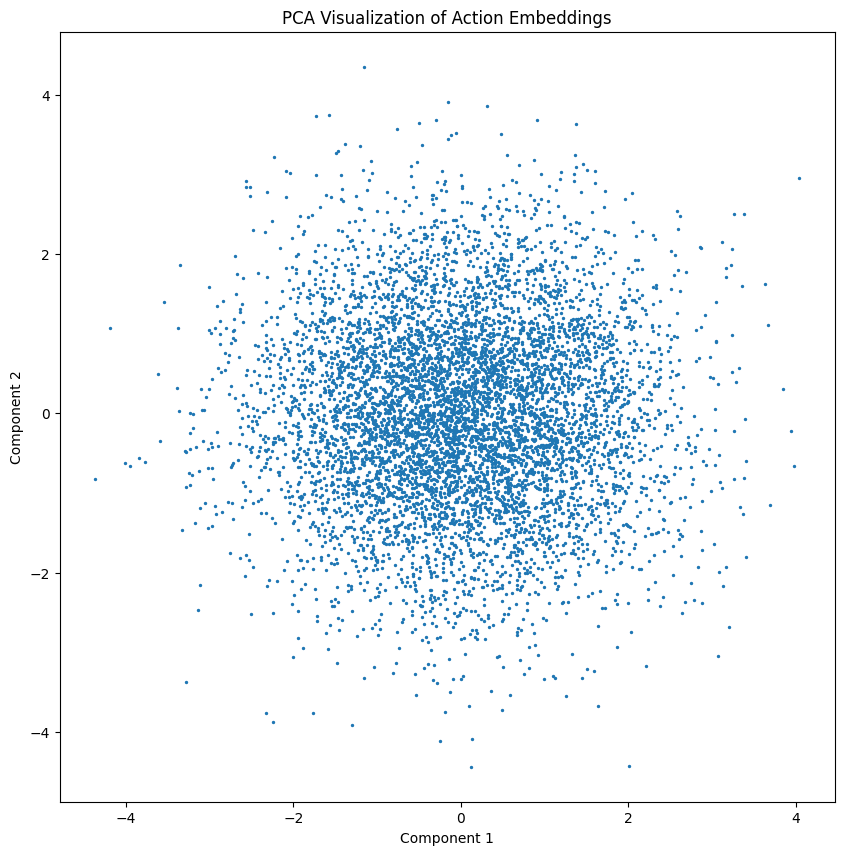

In [28]:
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap
import numpy as np

def tsne_dim_red(embeddings, n_components=2, random_state=42):
    """
    Reduce the dimensionality of the embeddings using t-SNE.
    
    Args:
        embeddings (np.ndarray): High-dimensional data of shape [N, D]
        n_components (int): Number of dimensions for the reduced space (default 2).
        random_state (int): Random seed for reproducibility.
        
    Returns:
        np.ndarray: Reduced embeddings of shape [N, n_components].
    """
    tsne = TSNE(n_components=n_components, random_state=random_state)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

def umap_dim_red(embeddings, n_components=2, random_state=42):
    """
    Reduce the dimensionality of the embeddings using UMAP.
    
    Args:
        embeddings (np.ndarray): High-dimensional data of shape [N, D]
        n_components (int): Number of dimensions for the reduced space (default 2).
        random_state (int): Random seed for reproducibility.
        
    Returns:
        np.ndarray: Reduced embeddings of shape [N, n_components].
    """
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    embeddings_2d = reducer.fit_transform(embeddings)
    return embeddings_2d

def pca_dim_red(embeddings, n_components=2):
    """
    Reduce the dimensionality of the embeddings using PCA.
    
    Returns:
        embeddings_pca (np.ndarray): Reduced embeddings of shape [N, n_components].
        explained_variance (np.ndarray): Explained variance ratio for each principal component.
    """
    pca = PCA(n_components=n_components)
    embeddings_pca = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_
    return embeddings_pca, explained_variance

def plot_embeddings(embeddings_2d, title="Dimensionality Reduction", xlabel="Component 1", ylabel="Component 2"):
    """
    Plot 2D embeddings.
    
    Args:
        embeddings_2d (np.ndarray): 2D array of shape [N, 2].
        title (str): Title for the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def main():
    # For example, suppose we have a precomputed embedding matrix of shape (vocab_size, embed_dim)
    vocab_size = 7075  # number of actions
    embed_dim = 256     # embedding dimension
    # Generate random embeddings for demonstration; in practice, load your embeddings
    embeddings = np.random.randn(vocab_size, embed_dim)

    # --- PCA ---
    embeddings_pca, explained_variance = pca_dim_red(embeddings, n_components=2)
    print("PCA reduced shape:", embeddings_pca.shape)
    print("Explained variance ratio (PCA):", explained_variance)
    plot_embeddings(embeddings_pca, title="PCA Visualization of Action Embeddings")

    # --- t-SNE ---
    # embeddings_tsne = tsne_dim_red(embeddings)
    # print("t-SNE reduced shape:", embeddings_tsne.shape)
    # plot_embeddings(embeddings_tsne, title="t-SNE Visualization of Action Embeddings")

    # --- UMAP ---
    # embeddings_umap = umap_dim_red(embeddings)
    # print("UMAP reduced shape:", embeddings_umap.shape)
    # plot_embeddings(embeddings_umap, title="UMAP Visualization of Action Embeddings")

if __name__ == '__main__':
    main()




K-means found 2 clusters.


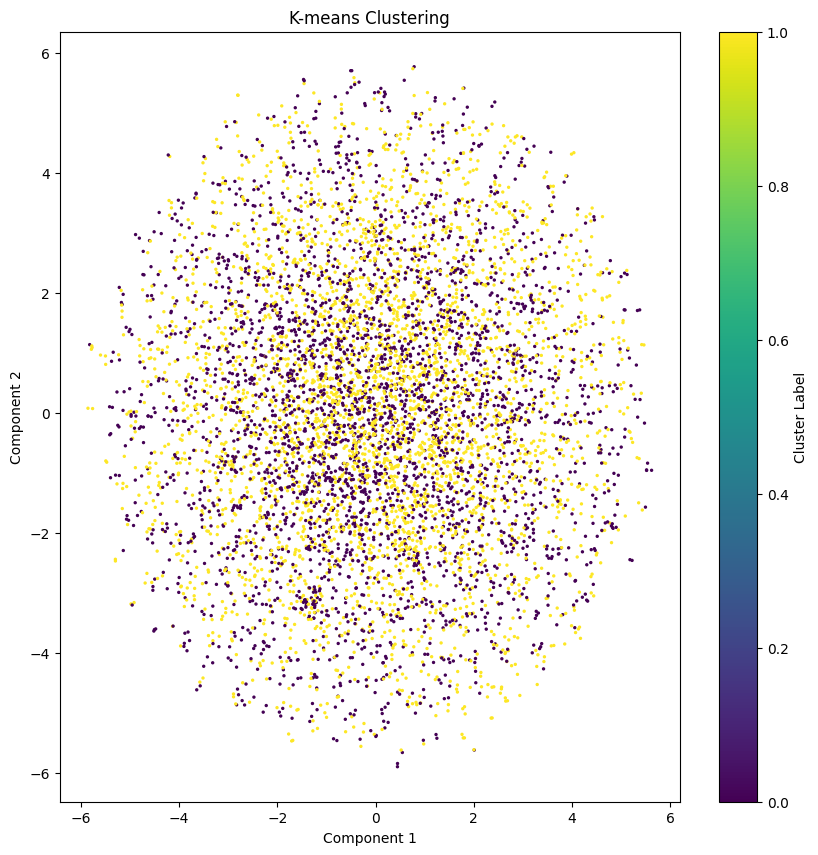

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE

def kmeans_clustering(embeddings, n_clusters):
    """
    Cluster the embeddings using K-means.
    
    Args:
        embeddings (np.ndarray): High-dimensional embeddings [N, D].
        n_clusters (int): Number of clusters.
    
    Returns:
        np.ndarray: Cluster labels of shape [N].
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

def dbscan_clustering(embeddings, eps=3.0, min_samples=10):
    """
    Cluster the embeddings using DBSCAN.
    
    Args:
        embeddings (np.ndarray): High-dimensional embeddings [N, D].
        eps (float): Maximum distance between two samples for them to be considered as in the same neighborhood.
        min_samples (int): Minimum number of points to form a dense region.
    
    Returns:
        np.ndarray: Cluster labels of shape [N]. Noise points are labeled as -1.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(embeddings)
    return labels

def agglomerative_clustering(embeddings, n_clusters):
    """
    Cluster the embeddings using Agglomerative Clustering.
    
    Args:
        embeddings (np.ndarray): High-dimensional embeddings [N, D].
        n_clusters (int): Number of clusters.
    
    Returns:
        np.ndarray: Cluster labels of shape [N].
    """
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg.fit_predict(embeddings)
    return labels

def plot_clusters(embeddings, labels, title="Clusters"):
    """
    Reduce embeddings to 2D using t-SNE and plot the clusters.
    
    Args:
        embeddings (np.ndarray): High-dimensional embeddings [N, D].
        labels (np.ndarray): Cluster labels [N].
        title (str): Title for the plot.
    """
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', s=2)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

def main():
    # Generate a random embedding matrix for demonstration.
    # In practice, replace this with your actual embeddings.
    vocab_size = 7075  # number of actions
    embed_dim = 256    # embedding dimension
    embeddings = np.random.randn(vocab_size, embed_dim)
    
    # # --- K-means Clustering ---
    n_clusters = 2
    labels_kmeans = kmeans_clustering(embeddings, n_clusters)
    print("K-means found", len(np.unique(labels_kmeans)), "clusters.")
    plot_clusters(embeddings, labels_kmeans, title="K-means Clustering")
    
    # # --- DBSCAN Clustering ---
    # n_clusters_dbscan = 3
    # labels_dbscan = dbscan_clustering(embeddings, eps=10.0, min_samples=n_clusters_dbscan)
    # # Count clusters (exclude noise if labeled as -1)
    # n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
    # print("DBSCAN found", n_clusters_dbscan, "clusters (excluding noise).")
    # plot_clusters(embeddings, labels_dbscan, title="DBSCAN Clustering")
    
    # # --- Agglomerative Clustering ---
    # n_clusters_agg = 3
    # labels_agg = agglomerative_clustering(embeddings, n_clusters_agg)
    # print("Agglomerative clustering found", len(np.unique(labels_agg)), "clusters.")
    # plot_clusters(embeddings, labels_agg, title="Agglomerative Clustering")

if __name__ == '__main__':
    main()


k=2: silhouette score = 0.0034
k=3: silhouette score = 0.0030
k=4: silhouette score = 0.0029
k=5: silhouette score = 0.0030
k=6: silhouette score = 0.0030
k=7: silhouette score = 0.0029
k=8: silhouette score = 0.0029
k=9: silhouette score = 0.0030
k=10: silhouette score = 0.0031
k=11: silhouette score = 0.0031
k=12: silhouette score = 0.0031
k=13: silhouette score = 0.0030
k=14: silhouette score = 0.0030
k=15: silhouette score = 0.0030
k=16: silhouette score = 0.0030
k=17: silhouette score = 0.0030
k=18: silhouette score = 0.0029
k=19: silhouette score = 0.0030
k=20: silhouette score = 0.0030
Best number of clusters: 2
Best silhouette score: 0.0033670190845577173


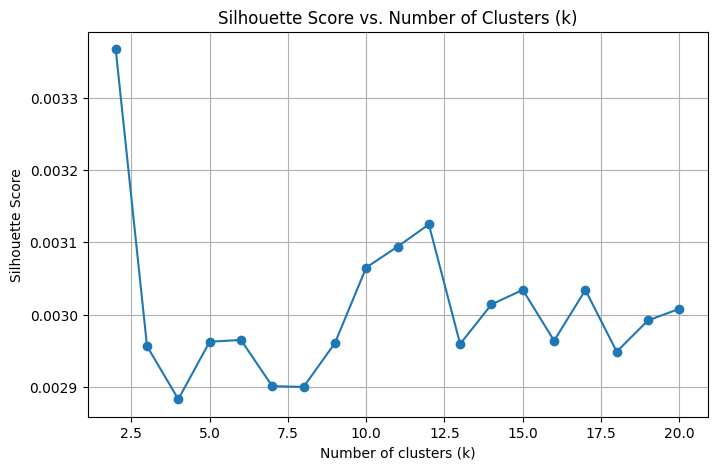

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def tune_kmeans(embeddings, k_range=(2, 21), random_state=42):
    """
    Tune the number of clusters for K-means by maximizing the silhouette score.

    Args:
        embeddings (np.ndarray): High-dimensional data of shape [N, D].
        k_range (tuple): A tuple (min_k, max_k) indicating the range of k values to try.
        random_state (int): Random seed for reproducibility.

    Returns:
        best_k (int): The number of clusters with the best silhouette score.
        best_score (float): The highest silhouette score obtained.
        silhouette_scores (list): List of silhouette scores for each k.
        best_labels (np.ndarray): Cluster labels corresponding to best_k.
    """
    silhouette_scores = []
    best_score = -1
    best_k = None
    best_labels = None

    for k in range(k_range[0], k_range[1]):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)
        silhouette_scores.append(score)
        print(f"k={k}: silhouette score = {score:.4f}")
        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels

    return best_k, best_score, silhouette_scores, best_labels

def plot_silhouette_scores(scores, k_range=(2, 21)):
    """
    Plot silhouette scores for different values of k.

    Args:
        scores (list): Silhouette scores for each k in the range.
        k_range (tuple): The range of k values (min_k, max_k).
    """
    k_values = list(range(k_range[0], k_range[1]))
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, scores, marker='o', linestyle='-')
    plt.title("Silhouette Score vs. Number of Clusters (k)")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

def main():
    # Example: generate a random embeddings matrix.
    # In practice, replace this with your actual embeddings.
    vocab_size = 7075  # number of actions
    embed_dim = 256    # embedding dimension
    embeddings = np.random.randn(vocab_size, embed_dim)

    # Tune k-means clustering: try values from 2 to 20.
    best_k, best_score, scores, best_labels = tune_kmeans(embeddings, k_range=(2, 21))
    print("Best number of clusters:", best_k)
    print("Best silhouette score:", best_score)

    # Plot silhouette scores.
    plot_silhouette_scores(scores, k_range=(2, 21))

if __name__ == '__main__':
    main()


k = 2, inertia = 1809229.8050
k = 3, inertia = 1804761.5608
k = 4, inertia = 1801042.3655
k = 5, inertia = 1797918.9142
k = 6, inertia = 1795204.6624
k = 7, inertia = 1792954.1136
k = 8, inertia = 1790722.2185
k = 9, inertia = 1788775.8825
k = 10, inertia = 1786801.7322
k = 11, inertia = 1785067.4460
k = 12, inertia = 1783898.0031
k = 13, inertia = 1782218.6764
k = 14, inertia = 1780817.8842
k = 15, inertia = 1779375.7379
k = 16, inertia = 1778101.0173
k = 17, inertia = 1776442.8272
k = 18, inertia = 1775341.7936
k = 19, inertia = 1774066.4259
k = 20, inertia = 1772840.4137
k = 21, inertia = 1771765.9847
k = 22, inertia = 1770756.9577
k = 23, inertia = 1769304.9330
k = 24, inertia = 1768416.3079
k = 25, inertia = 1767481.6659
k = 26, inertia = 1766754.6850
k = 27, inertia = 1765893.2238
k = 28, inertia = 1765368.8829
k = 29, inertia = 1763939.5427
k = 30, inertia = 1763887.1346
k = 31, inertia = 1762650.7696
k = 32, inertia = 1761533.5964
k = 33, inertia = 1761350.5715
k = 34, inertia 

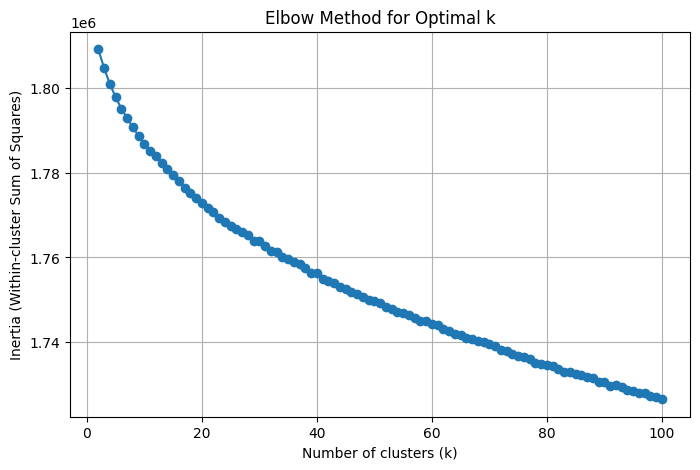

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def tune_kmeans_elbow(embeddings, k_range=(2, 101), random_state=42):
    """
    Computes K-means inertia (within-cluster sum of squares) for a range of k values.
    
    Args:
        embeddings (np.ndarray): High-dimensional data of shape [N, D].
        k_range (tuple): A tuple (min_k, max_k) indicating the range of k values to try.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        k_values (list): List of k values tried.
        inertia_values (list): Inertia (sum of squared distances) for each k.
    """
    inertia_values = []
    k_values = list(range(k_range[0], k_range[1]))
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(embeddings)
        inertia_values.append(kmeans.inertia_)
        print(f"k = {k}, inertia = {kmeans.inertia_:.4f}")
    return k_values, inertia_values

def plot_elbow(k_values, inertia_values):
    """
    Plot the inertia values (elbow plot) for different k values.
    
    Args:
        k_values (list): List of k values.
        inertia_values (list): Inertia for each k.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia_values, marker='o', linestyle='-')
    plt.title("Elbow Method for Optimal k")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Within-cluster Sum of Squares)")
    plt.grid(True)
    plt.show()

def main():
    # For demonstration, generate random embeddings.
    vocab_size = 7075    # e.g., number of actions
    embed_dim = 256      # embedding dimension
    embeddings = np.random.randn(vocab_size, embed_dim)
    
    # Compute inertia for different values of k.
    k_values, inertia_values = tune_kmeans_elbow(embeddings, k_range=(2, 101))
    
    # Plot the elbow curve.
    plot_elbow(k_values, inertia_values)

if __name__ == '__main__':
    main()


Cosine similarity matrix shape: (7075, 7075)


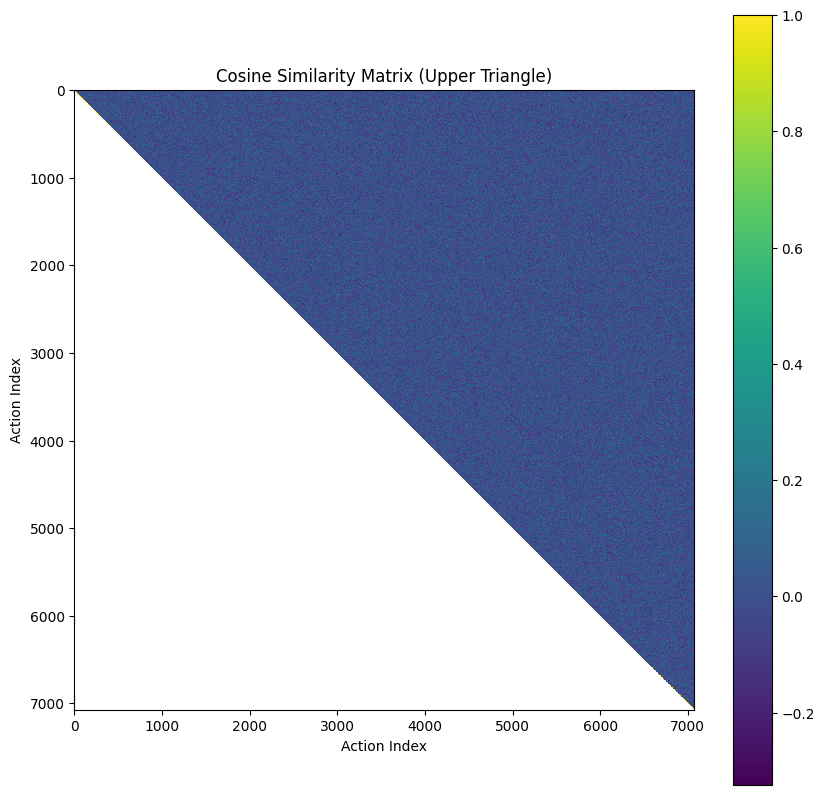

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_similarity_matrix(embeddings: np.ndarray) -> np.ndarray:
    """
    Compute the cosine similarity matrix between rows of embeddings.
    
    Args:
        embeddings (np.ndarray): Array of shape [N, D] where N is the number of actions
                                 and D is the embedding dimension.
    
    Returns:
        np.ndarray: Cosine similarity matrix of shape [N, N].
    """
    # Normalize the embeddings: each row vector is divided by its norm.
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    # Avoid division by zero
    norms[norms == 0] = 1e-8
    normalized_embeddings = embeddings / norms

    # Compute cosine similarity as the dot product between normalized vectors.
    cosine_sim = np.dot(normalized_embeddings, normalized_embeddings.T)
    return cosine_sim

def extract_upper_triangle(sim_matrix: np.ndarray) -> np.ndarray:
    """
    Extract the upper triangular part of a symmetric similarity matrix.
    
    Args:
        sim_matrix (np.ndarray): Square similarity matrix of shape [N, N].
    
    Returns:
        np.ndarray: A new matrix of shape [N, N] where the lower triangular part is set to NaN.
    """
    # Create an upper-triangular boolean mask (including the diagonal).
    mask = np.triu(np.ones(sim_matrix.shape, dtype=bool))
    # Use the mask to set the lower triangle to NaN (or you could set it to 0 if you prefer).
    upper_tri = np.where(mask, sim_matrix, np.nan)
    return upper_tri

def plot_similarity_matrix(sim_matrix: np.ndarray, title: str = "Cosine Similarity (Upper Triangle)"):
    """
    Plot a similarity matrix using matplotlib.
    
    Args:
        sim_matrix (np.ndarray): 2D array to plot.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(sim_matrix, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Action Index")
    plt.ylabel("Action Index")
    plt.colorbar()
    plt.show()

def main():
    # For demonstration, let's generate a random embedding matrix.
    vocab_size = 7075   # number of actions
    embed_dim = 256     # embedding dimension
    embeddings = np.random.randn(vocab_size, embed_dim,)

    # Compute the full cosine similarity matrix.
    cosine_sim = cosine_similarity_matrix(embeddings)
    print("Cosine similarity matrix shape:", cosine_sim.shape)

    # Extract only the upper triangular part.
    cosine_sim_upper = extract_upper_triangle(cosine_sim)
    
    # Plot the upper triangular cosine similarity matrix.
    plot_similarity_matrix(cosine_sim_upper, title="Cosine Similarity Matrix (Upper Triangle)")

if __name__ == '__main__':
    main()


In [1]:
import numpy as np

class ActionSpace:
    def __init__(self, color_selection_dict, selection_dict, transformation_dict):
        """
        Args:
            color_selection_dict (dict): Maps an integer index to a function wrapper (partial)
                                         for color selection.
            selection_dict (dict): Maps an integer index to a function wrapper for grid selection.
            transformation_dict (dict): Maps an integer index to a function wrapper for transformations.
        """
        self.color_selection_dict = color_selection_dict
        self.selection_dict = selection_dict
        self.transformation_dict = transformation_dict

    def action_to_string(self, action, only_color=False, only_selection=False, only_transformation=False):
        """
        Convert an action vector into a human-readable description.

        Args:
            action (array-like): The action vector (expected length 3) where:
                                 - action[0]: index for the color selection function.
                                 - action[1]: index for the grid selection function.
                                 - action[2]: index for the transformation function.
            only_color (bool): If True, return only the color selection string.
            only_selection (bool): If True, return only the grid selection string.
            only_transformation (bool): If True, return only the transformation string.

        Returns:
            dict or str: A dictionary with keys 'color_selection', 'selection', and 'transformation'
                         if no flag is provided; otherwise, the corresponding string.
        """
        # Cast components to integer indices.
        color_index = int(action[0])
        selection_index = int(action[1])
        transformation_index = int(action[2])

        # Retrieve and format the color selection function.
        color_sel_partial = self.color_selection_dict[color_index]
        func_name = color_sel_partial.func.__name__
        args_str = ', '.join(f'{k}={v}' for k, v in color_sel_partial.keywords.items())
        color_sel_str = f"{func_name}({args_str})"

        # Retrieve and format the grid selection function.
        selection_partial = self.selection_dict[selection_index]
        func_name = selection_partial.func.__name__
        args_str = ', '.join(f'{k}={v}' for k, v in selection_partial.keywords.items())
        selection_str = f"{func_name}({args_str})"

        # Retrieve and format the transformation function.
        transformation_partial = self.transformation_dict[transformation_index]
        func_name = transformation_partial.func.__name__
        args_str = ', '.join(f'{k}={v}' for k, v in transformation_partial.keywords.items())
        transformation_str = f"{func_name}({args_str})"

        action_dict = {
            'color_selection': color_sel_str,
            'selection': selection_str,
            'transformation': transformation_str
        }

        if only_color:
            return action_dict['color_selection']
        if only_selection:
            return action_dict['selection']
        if only_transformation:
            return action_dict['transformation']

        return action_dict

# For testing, we define a simple dummy class to simulate partial function objects.
class DummyPartial:
    def __init__(self, func, keywords):
        self.func = func
        self.keywords = keywords

# For our test, we create dummy dictionaries for each of the three components.
dummy_color_dict = {
    0: DummyPartial(func=lambda: None, keywords={'param': 0}),
    1: DummyPartial(func=lambda: None, keywords={'param': 1}),
}
# Give the lambda functions a name.
dummy_color_dict[0].func.__name__ = "mostcolor"
dummy_color_dict[1].func.__name__ = "leastcolor"

dummy_selection_dict = {
    0: DummyPartial(func=lambda: None, keywords={'region': 'full'}),
    1: DummyPartial(func=lambda: None, keywords={'region': 'rectangle'}),
}
dummy_selection_dict[0].func.__name__ = "select_all"
dummy_selection_dict[1].func.__name__ = "select_rectangles"

dummy_transformation_dict = {
    0: DummyPartial(func=lambda: None, keywords={'op': 'rotate90'}),
    1: DummyPartial(func=lambda: None, keywords={'op': 'flipv'}),
}
dummy_transformation_dict[0].func.__name__ = "rotate90"
dummy_transformation_dict[1].func.__name__ = "flipv"

# Main test function.
def main():
    # Create an ActionSpace instance using our dummy dictionaries.
    action_space = ActionSpace(dummy_color_dict, dummy_selection_dict, dummy_transformation_dict)

    # Example protoaction: a vector with indices for each of the three components.
    protoaction = [1, 0, 1]  # For example: use leastcolor, select_all, and flipv.
    action_description = action_space.action_to_string(protoaction)
    print("Action description:", action_description)

if __name__ == '__main__':
    main()


Action description: {'color_selection': 'leastcolor(param=1)', 'selection': 'select_all(region=full)', 'transformation': 'flipv(op=flipv)'}


# Encoded_Exploration

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from world_model.transformer import TransformerLayer

# Go up one directory to import utils
from utils.util import set_device

DEVICE = set_device('transformer.py')

# ==================== EncoderTransformer Class ====================

class EncoderTransformer(nn.Module):
    def __init__(self, config):
        """
        config should have at least:
          - max_rows, max_cols: maximum grid dimensions.
          - emb_dim: embedding dimension.
          - vocab_size: size of the color vocabulary.
          - max_len: usually R * C (so that 2*max_len equals the flattened spatial tokens).
          - scaled_position_embeddings: bool, whether to use scaled positional embeddings.
          - latent_dim: dimension of the latent projection.
          - latent_projection_bias: bool, whether to use bias in the latent projection.
          - variational: bool, whether to produce a log-variance.
          - num_layers: number of transformer layers.
          - transformer_layer: a sub-config with fields:
              * dropout_rate
              * num_heads
              * use_bias
              * ffn_dim
        """
        super(EncoderTransformer, self).__init__()
        self.config = config
        self.target_state = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.long).to(DEVICE)

        # Position embeddings.
        if config.scaled_position_embeddings:
            self.pos_row_embed = nn.Embedding(1, config.emb_dim).to(DEVICE)
            self.pos_col_embed = nn.Embedding(1, config.emb_dim).to(DEVICE)
        else:
            self.pos_row_embed = nn.Embedding(config.max_rows, config.emb_dim).to(DEVICE)
            self.pos_col_embed = nn.Embedding(config.max_cols, config.emb_dim).to(DEVICE)

        # Colors and channels embeddings.
        self.colors_embed = nn.Embedding(config.vocab_size, config.emb_dim).to(DEVICE)

        # Grid shapes embeddings.
        self.grid_shapes_row_embed = nn.Embedding(config.max_rows, config.emb_dim).to(DEVICE)
        self.grid_shapes_col_embed = nn.Embedding(config.max_cols, config.emb_dim).to(DEVICE)

        # Optionally, normalize grid shape embeddings.
        self.grid_shape_norm = nn.LayerNorm(config.emb_dim, elementwise_affine=True).to(DEVICE)

        # CLS token embedding.
        self.cls_token = nn.Embedding(1, config.emb_dim).to(DEVICE)

        # Dropout for embedding.
        self.embed_dropout = nn.Dropout(config.dropout_rate)

        # An extra normalization applied to the entire embedding sequence.
        self.input_layer_norm = nn.LayerNorm(config.emb_dim, elementwise_affine=True).to(DEVICE)

        # Transformer layers.
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(config) for _ in range(config.num_layers)
        ]).to(DEVICE)

        # CLS layer normalization.
        self.cls_layer_norm = nn.LayerNorm(config.emb_dim, elementwise_affine=True).to(DEVICE)
        with torch.no_grad():
            self.cls_layer_norm.weight.fill_(1.0)
        self.cls_layer_norm.weight.requires_grad = False
        if not config.use_bias:
            if self.cls_layer_norm.bias is not None:
                self.cls_layer_norm.bias.data.zero_().to(DEVICE)
                self.cls_layer_norm.bias.requires_grad = False

        # Latent projection.
        self.latent_mu = nn.Linear(config.emb_dim, config.latent_dim, bias=config.latent_projection_bias).to(DEVICE)
        if config.variational:
            self.latent_logvar = nn.Linear(config.emb_dim, config.latent_dim, bias=config.latent_projection_bias)
        else:
            self.latent_logvar = None

        self.to(DEVICE)

    def forward(self, state, shape, dropout_eval):
        # Validate state and shape values.
        assert torch.all(state >= 0) and torch.all(state < self.config.vocab_size), \
            f"Input colors should be between 0 and {self.config.vocab_size - 1}"
        assert torch.all(shape[:, 0] >= 0) and torch.all(shape[:, 0] < self.config.max_rows), \
            f"Input rows should be between 0 and {self.config.max_rows - 1}"
        assert torch.all(shape[:, 1] >= 0) and torch.all(shape[:, 1] < self.config.max_cols), \
            f"Input cols should be between 0 and {self.config.max_cols - 1}"

        x = self.embed_grids(state, shape, dropout_eval)
        x = self.input_layer_norm(x)
        pad_mask = self.make_pad_mask(shape)
        for layer in self.transformer_layers:
            x = layer(embeddings=x, dropout_eval=dropout_eval, pad_mask=pad_mask)
        cls_embed = x[:, 0, :]
        cls_embed = self.cls_layer_norm(cls_embed)
        latent_mu = self.latent_mu(cls_embed).to(torch.float32)
        if self.config.variational:
            latent_logvar = self.latent_logvar(cls_embed).to(torch.float32)
        else:
            latent_logvar = None
        return latent_mu

    def embed_grids(self, state, shape, dropout_eval):
        config = self.config
        if config.scaled_position_embeddings:
            pos_row_indices = torch.zeros(config.max_rows, dtype=torch.long, device=DEVICE)
            pos_row_embed = self.pos_row_embed(pos_row_indices)
            pos_col_indices = torch.zeros(config.max_cols, dtype=torch.long, device=DEVICE)
            pos_col_embed = self.pos_col_embed(pos_col_indices)
            pos_row_factors = torch.arange(1, config.max_rows + 1, device=DEVICE).unsqueeze(1).type_as(pos_row_embed)
            pos_row_embeds = pos_row_factors * pos_row_embed
            pos_col_factors = torch.arange(1, config.max_cols + 1, device=DEVICE).unsqueeze(1).type_as(pos_col_embed)
            pos_col_embeds = pos_col_factors * pos_col_embed
            pos_embed = pos_row_embeds.unsqueeze(1) + pos_col_embeds.unsqueeze(0)
        else:
            pos_row_indices = torch.arange(config.max_rows, dtype=torch.long, device=DEVICE)
            pos_row_embed = self.pos_row_embed(pos_row_indices)
            pos_col_indices = torch.arange(config.max_cols, dtype=torch.long, device=DEVICE)
            pos_col_embed = self.pos_col_embed(pos_col_indices)
            pos_embed = pos_row_embed.unsqueeze(1) + pos_col_embed.unsqueeze(0)

        colors_embed = self.colors_embed(state)
        x = colors_embed + pos_embed
        B = x.shape[0]
        x = x.view(B, -1, x.shape[-1])
        grid_shapes_row = shape[:, 0].long()
        grid_shapes_row_embed = self.grid_shapes_row_embed(grid_shapes_row)
        grid_shapes_row_embed = self.grid_shape_norm(grid_shapes_row_embed).unsqueeze(1)
        grid_shapes_col = shape[:, 1].long()
        grid_shapes_col_embed = self.grid_shapes_col_embed(grid_shapes_col)
        grid_shapes_col_embed = self.grid_shape_norm(grid_shapes_col_embed).unsqueeze(1)
        grid_shapes_embed = torch.cat([grid_shapes_row_embed, grid_shapes_col_embed], dim=1)
        x = torch.cat([grid_shapes_embed, x], dim=1)
        cls_token = self.cls_token(torch.zeros(x.shape[0], 1, dtype=torch.long, device=DEVICE))
        x = torch.cat([cls_token, x], dim=1)
        expected_seq_len = 1 + 2 + config.max_len
        assert x.shape[1] == expected_seq_len, f"Expected sequence length {expected_seq_len}, got {x.shape[1]}"
        if not dropout_eval:
            x = self.embed_dropout(x)
        return x

    def make_pad_mask(self, shape):
        B = shape.shape[0]
        row_arange = torch.arange(self.config.max_rows, device=DEVICE).view(1, self.config.max_rows)
        row_mask = row_arange < shape[:, 0].view(B, 1)
        col_arange = torch.arange(self.config.max_cols, device=DEVICE).view(1, self.config.max_cols)
        col_mask = col_arange < shape[:, 1].view(B, 1)
        row_mask = row_mask.unsqueeze(2)
        col_mask = col_mask.unsqueeze(1)
        pad_mask = row_mask & col_mask
        pad_mask = pad_mask.view(B, 1, -1)
        ones_mask = torch.ones(B, 1, 1 + 2, dtype=torch.bool, device=DEVICE)
        pad_mask = torch.cat([ones_mask, pad_mask], dim=-1)
        pad_mask = pad_mask.unsqueeze(2) & pad_mask.unsqueeze(3)
        return pad_mask

    def encode(self, state, shape, new_episode=False):
        current_state = state[:, :, 1] + 1
        target_state = state[:, :, 0] + 1
        current_shape = shape[0, :] - 1
        target_shape = shape[1, :] - 1
        current_state = current_state.unsqueeze(0)
        target_state = target_state.unsqueeze(0)
        current_shape = current_shape.unsqueeze(0)
        target_shape = target_shape.unsqueeze(0)
        if torch.equal(target_state, self.target_state):
            embedded_target_state = self.target_state_embed
        else:
            with torch.no_grad():
                target_state = target_state.long()
                target_shape = target_shape.long()
                embedded_target_state = self.forward(target_state, target_shape, dropout_eval=True)
                self.target_state_embed = embedded_target_state
        with torch.no_grad():
            current_state = current_state.long()
            current_shape = current_shape.long()
            current_state_embed = self.forward(current_state, current_shape, dropout_eval=True)
            x = torch.cat([current_state_embed, self.target_state_embed], dim=1)
            x = x.squeeze(0)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), os.path.join(path, 'encoder.pt'))

    def load_weights(self, path: str):
        weight_path = os.path.join(path, 'encoder.pt')
        if not os.path.exists(weight_path):
            raise FileNotFoundError(f"Weight file {weight_path} not found.")
        self.load_state_dict(torch.load(weight_path, map_location=torch.device('cpu')))

    @property
    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# ==================== Main Script ====================

def main():
    weights_folder = r"C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\2 Haphaestus"
    memory_chunk_path = r"C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\2 Haphaestus\Memory\memory_chunks\sequential_memory_chunk_0.pt"

    # ------------------- Configuration -------------------
    class Config:
        def __init__(self):
            self.max_rows = 30
            self.max_cols = 30
            self.emb_dim = 172
            self.vocab_size = 11
            self.max_len = self.max_rows * self.max_cols   # 900 tokens expected in the grid
            self.scaled_position_embeddings = False
            self.latent_dim = 512
            self.latent_projection_bias = False
            self.variational = False
            self.num_layers = 3
            self.use_bias = True
            self.dropout_rate = 0.0
            self.num_heads = 4                    # Required by TransformerLayer
            self.attention_dropout_rate = 0.0     # Required by TransformerLayer
            self.mlp_dim_factor = 2               # Required by MlpBlock
            self.activation = "relu"              # New attribute required by MlpBlock
            self.transformer_layer = type('TransformerLayerConfig', (), {
                'dropout_rate': 0.0,
                'num_heads': self.num_heads,
                'use_bias': True,
                'ffn_dim': 512
            })()
    config = Config()
    print('config.bias:', config.use_bias)
    encoder = EncoderTransformer(config)
    
    # ------------------- Load Weights -------------------
    try:
        encoder.load_weights(weights_folder)
        print("Encoder weights loaded from encoder.pt.")
    except Exception as e:
        print(f"Failed to load encoder weights: {e}")
        return

    # ------------------- Load Memory Chunk -------------------
    if not os.path.exists(memory_chunk_path):
        print(f"Memory chunk file {memory_chunk_path} not found.")
        return
    try:
        memory_chunk = torch.load(memory_chunk_path, map_location='cpu')
        print(f"Loaded memory chunk with {len(memory_chunk)} samples.")
    except Exception as e:
        print(f"Error loading memory chunk: {e}")
        return

    # ------------------- Encode Samples -------------------
    encoded_states_list = []
    for i, sample in enumerate(memory_chunk):
        try:
            state, shape = sample
        except Exception as e:
            print(f"Sample {i} is not in the expected format: {e}")
            continue
        with torch.no_grad():
            encoded = encoder.encode(state, shape)
        encoded_states_list.append(encoded.cpu().numpy())
        if (i + 1) % 100 == 0:
            print(f"Encoded {i + 1} samples.")
    if len(encoded_states_list) == 0:
        print("No states encoded. Exiting.")
        return
    encoded_states = np.stack(encoded_states_list, axis=0)
    print("All states encoded. Final encoded states matrix shape:", encoded_states.shape)

if __name__ == '__main__':
    main()

Using device: cpu for transformer.py
config.bias: True
Encoder weights loaded from encoder.pt.
Error loading memory chunk: [Errno 13] Permission denied: 'C:\\Users\\giamb\\OneDrive\\Documents\\2 Uni\\Associations\\2 Haphaestus\\Memory\\memory_chunks\\sequential_memory_chunk_0.pt'


Doubt to ask Francesco, I have got this error regarding unexpected keys, what do I do?
- In the next code, I'll set self.load_state_dict(state_dict, strict=False) in load_weights=False to make it run, is it problematic to disregard it?

In [19]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from world_model.transformer import TransformerLayer

# Go up one directory to import utils
from utils.util import set_device

DEVICE = set_device('transformer.py')

# ==================== EncoderTransformer Class ====================

class EncoderTransformer(nn.Module):
    def __init__(self, config):
        """
        config should have at least:
          - max_rows, max_cols: maximum grid dimensions.
          - emb_dim: embedding dimension.
          - vocab_size: size of the color vocabulary.
          - max_len: usually R * C (so that 2*max_len equals the flattened spatial tokens).
          - scaled_position_embeddings: bool, whether to use scaled positional embeddings.
          - latent_dim: dimension of the latent projection.
          - latent_projection_bias: bool, whether to use bias in the latent projection.
          - variational: bool, whether to produce a log-variance.
          - num_layers: number of transformer layers.
          - transformer_layer: a sub-config with fields:
              * dropout_rate
              * num_heads
              * use_bias
              * ffn_dim
        """
        super(EncoderTransformer, self).__init__()
        self.config = config
        self.target_state = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.long).to(DEVICE)

        # Position embeddings.
        if config.scaled_position_embeddings:
            self.pos_row_embed = nn.Embedding(1, config.emb_dim).to(DEVICE)
            self.pos_col_embed = nn.Embedding(1, config.emb_dim).to(DEVICE)
        else:
            self.pos_row_embed = nn.Embedding(config.max_rows, config.emb_dim).to(DEVICE)
            self.pos_col_embed = nn.Embedding(config.max_cols, config.emb_dim).to(DEVICE)

        # Colors and channels embeddings.
        self.colors_embed = nn.Embedding(config.vocab_size, config.emb_dim).to(DEVICE)

        # Grid shapes embeddings.
        self.grid_shapes_row_embed = nn.Embedding(config.max_rows, config.emb_dim).to(DEVICE)
        self.grid_shapes_col_embed = nn.Embedding(config.max_cols, config.emb_dim).to(DEVICE)

        # Optionally, normalize grid shape embeddings.
        self.grid_shape_norm = nn.LayerNorm(config.emb_dim, elementwise_affine=True).to(DEVICE)

        # CLS token embedding.
        self.cls_token = nn.Embedding(1, config.emb_dim).to(DEVICE)

        # Dropout for embedding.
        self.embed_dropout = nn.Dropout(config.dropout_rate)

        # An extra normalization applied to the entire embedding sequence.
        self.input_layer_norm = nn.LayerNorm(config.emb_dim, elementwise_affine=True).to(DEVICE)

        # Transformer layers.
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(config) for _ in range(config.num_layers)
        ]).to(DEVICE)

        # CLS layer normalization.
        self.cls_layer_norm = nn.LayerNorm(config.emb_dim, elementwise_affine=True).to(DEVICE)
        with torch.no_grad():
            self.cls_layer_norm.weight.fill_(1.0)
        self.cls_layer_norm.weight.requires_grad = False
        if not config.use_bias:
            if self.cls_layer_norm.bias is not None:
                self.cls_layer_norm.bias.data.zero_().to(DEVICE)
                self.cls_layer_norm.bias.requires_grad = False

        # Latent projection.
        self.latent_mu = nn.Linear(config.emb_dim, config.latent_dim, bias=config.latent_projection_bias).to(DEVICE)
        if config.variational:
            self.latent_logvar = nn.Linear(config.emb_dim, config.latent_dim, bias=config.latent_projection_bias)
        else:
            self.latent_logvar = None

        self.to(DEVICE)

    def forward(self, state, shape, dropout_eval):
        # Validate state and shape values.
        assert torch.all(state >= 0) and torch.all(state < self.config.vocab_size), \
            f"Input colors should be between 0 and {self.config.vocab_size - 1}"
        assert torch.all(shape[:, 0] >= 0) and torch.all(shape[:, 0] < self.config.max_rows), \
            f"Input rows should be between 0 and {self.config.max_rows - 1}"
        assert torch.all(shape[:, 1] >= 0) and torch.all(shape[:, 1] < self.config.max_cols), \
            f"Input cols should be between 0 and {self.config.max_cols - 1}"

        x = self.embed_grids(state, shape, dropout_eval)
        x = self.input_layer_norm(x)
        pad_mask = self.make_pad_mask(shape)
        for layer in self.transformer_layers:
            x = layer(embeddings=x, dropout_eval=dropout_eval, pad_mask=pad_mask)
        cls_embed = x[:, 0, :]
        cls_embed = self.cls_layer_norm(cls_embed)
        latent_mu = self.latent_mu(cls_embed).to(torch.float32)
        if self.config.variational:
            latent_logvar = self.latent_logvar(cls_embed).to(torch.float32)
        else:
            latent_logvar = None
        return latent_mu

    def embed_grids(self, state, shape, dropout_eval):
        config = self.config
        if config.scaled_position_embeddings:
            pos_row_indices = torch.zeros(config.max_rows, dtype=torch.long, device=DEVICE)
            pos_row_embed = self.pos_row_embed(pos_row_indices)
            pos_col_indices = torch.zeros(config.max_cols, dtype=torch.long, device=DEVICE)
            pos_col_embed = self.pos_col_embed(pos_col_indices)
            pos_row_factors = torch.arange(1, config.max_rows + 1, device=DEVICE).unsqueeze(1).type_as(pos_row_embed)
            pos_row_embeds = pos_row_factors * pos_row_embed
            pos_col_factors = torch.arange(1, config.max_cols + 1, device=DEVICE).unsqueeze(1).type_as(pos_col_embed)
            pos_col_embeds = pos_col_factors * pos_col_embed
            pos_embed = pos_row_embeds.unsqueeze(1) + pos_col_embeds.unsqueeze(0)
        else:
            pos_row_indices = torch.arange(config.max_rows, dtype=torch.long, device=DEVICE)
            pos_row_embed = self.pos_row_embed(pos_row_indices)
            pos_col_indices = torch.arange(config.max_cols, dtype=torch.long, device=DEVICE)
            pos_col_embed = self.pos_col_embed(pos_col_indices)
            pos_embed = pos_row_embed.unsqueeze(1) + pos_col_embed.unsqueeze(0)

        colors_embed = self.colors_embed(state)
        x = colors_embed + pos_embed
        B = x.shape[0]
        x = x.view(B, -1, x.shape[-1])
        grid_shapes_row = shape[:, 0].long()
        grid_shapes_row_embed = self.grid_shapes_row_embed(grid_shapes_row)
        grid_shapes_row_embed = self.grid_shape_norm(grid_shapes_row_embed).unsqueeze(1)
        grid_shapes_col = shape[:, 1].long()
        grid_shapes_col_embed = self.grid_shapes_col_embed(grid_shapes_col)
        grid_shapes_col_embed = self.grid_shape_norm(grid_shapes_col_embed).unsqueeze(1)
        grid_shapes_embed = torch.cat([grid_shapes_row_embed, grid_shapes_col_embed], dim=1)
        x = torch.cat([grid_shapes_embed, x], dim=1)
        cls_token = self.cls_token(torch.zeros(x.shape[0], 1, dtype=torch.long, device=DEVICE))
        x = torch.cat([cls_token, x], dim=1)
        expected_seq_len = 1 + 2 + config.max_len
        assert x.shape[1] == expected_seq_len, f"Expected sequence length {expected_seq_len}, got {x.shape[1]}"
        if not dropout_eval:
            x = self.embed_dropout(x)
        return x

    def make_pad_mask(self, shape):
        B = shape.shape[0]
        row_arange = torch.arange(self.config.max_rows, device=DEVICE).view(1, self.config.max_rows)
        row_mask = row_arange < shape[:, 0].view(B, 1)
        col_arange = torch.arange(self.config.max_cols, device=DEVICE).view(1, self.config.max_cols)
        col_mask = col_arange < shape[:, 1].view(B, 1)
        row_mask = row_mask.unsqueeze(2)
        col_mask = col_mask.unsqueeze(1)
        pad_mask = row_mask & col_mask
        pad_mask = pad_mask.view(B, 1, -1)
        ones_mask = torch.ones(B, 1, 1 + 2, dtype=torch.bool, device=DEVICE)
        pad_mask = torch.cat([ones_mask, pad_mask], dim=-1)
        pad_mask = pad_mask.unsqueeze(2) & pad_mask.unsqueeze(3)
        return pad_mask

    def encode(self, state, shape, new_episode=False):
        current_state = state[:, :, 1] + 1
        target_state = state[:, :, 0] + 1
        current_shape = shape[0, :] - 1
        target_shape = shape[1, :] - 1
        current_state = current_state.unsqueeze(0)
        target_state = target_state.unsqueeze(0)
        current_shape = current_shape.unsqueeze(0)
        target_shape = target_shape.unsqueeze(0)
        if torch.equal(target_state, self.target_state):
            embedded_target_state = self.target_state_embed
        else:
            with torch.no_grad():
                target_state = target_state.long()
                target_shape = target_shape.long()
                embedded_target_state = self.forward(target_state, target_shape, dropout_eval=True)
                self.target_state_embed = embedded_target_state
        with torch.no_grad():
            current_state = current_state.long()
            current_shape = current_shape.long()
            current_state_embed = self.forward(current_state, current_shape, dropout_eval=True)
            x = torch.cat([current_state_embed, self.target_state_embed], dim=1)
            x = x.squeeze(0)
        return x

    def save_weights(self, path: str):
        torch.save(self.state_dict(), os.path.join(path, 'encoder.pt'))

    def load_weights(self, path: str):
        weight_path = os.path.join(path, 'encoder.pt')
        if not os.path.exists(weight_path):
            raise FileNotFoundError(f"Weight file {weight_path} not found.")
        state_dict = torch.load(weight_path, map_location=torch.device('cpu'))
        self.load_state_dict(state_dict, strict=False)

    @property
    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# ==================== Main Script ====================

def main():
    weights_folder = r"C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\2 Haphaestus"
    memory_chunk_path = r"C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\2 Haphaestus\Memory\memory_chunks\sequential_memory_chunk_0.pt"

    # ------------------- Configuration -------------------
    class Config:
        def __init__(self):
            self.max_rows = 30
            self.max_cols = 30
            self.emb_dim = 172
            self.vocab_size = 11
            self.max_len = self.max_rows * self.max_cols   # 900 tokens expected in the grid
            self.scaled_position_embeddings = False
            self.latent_dim = 512
            self.latent_projection_bias = False
            self.variational = False
            self.num_layers = 2
            self.use_bias = False
            self.dropout_rate = 0.0
            self.num_heads = 4                    # Required by TransformerLayer
            self.attention_dropout_rate = 0.0     # Required by TransformerLayer
            self.mlp_dim_factor = 2               # Required by MlpBlock
            self.activation = "relu"              # New attribute required by MlpBlock
            self.transformer_layer = type('TransformerLayerConfig', (), {
                'dropout_rate': 0.0,
                'num_heads': self.num_heads,
                'use_bias': False,
                'ffn_dim': 512
            })()
    config = Config()
    encoder = EncoderTransformer(config)
    
    # ------------------- Load Weights -------------------
    try:
        encoder.load_weights(weights_folder)
        print("Encoder weights loaded from encoder.pt.")
    except Exception as e:
        print(f"Failed to load encoder weights: {e}")
        return

    # ------------------- Load Memory Chunk -------------------
    if not os.path.exists(memory_chunk_path):
        print(f"Memory chunk file {memory_chunk_path} not found.")
        return
    try:
        memory_chunk = torch.load(memory_chunk_path, map_location='cpu')
        print(f"Loaded memory chunk with {len(memory_chunk)} samples.")
    except Exception as e:
        print(f"Error loading memory chunk: {e}")
        return

    # ------------------- Encode Samples -------------------
    encoded_states_list = []
    for i, sample in enumerate(memory_chunk):
        try:
            state, shape = sample
        except Exception as e:
            print(f"Sample {i} is not in the expected format: {e}")
            continue
        with torch.no_grad():
            encoded = encoder.encode(state, shape)
        encoded_states_list.append(encoded.cpu().numpy())
        if (i + 1) % 100 == 0:
            print(f"Encoded {i + 1} samples.")
    if len(encoded_states_list) == 0:
        print("No states encoded. Exiting.")
        return
    encoded_states = np.stack(encoded_states_list, axis=0)
    print("All states encoded. Final encoded states matrix shape:", encoded_states.shape)

if __name__ == '__main__':
    main()

Using device: cpu for transformer.py
Encoder weights loaded from encoder.pt.
Error loading memory chunk: [Errno 13] Permission denied: 'C:\\Users\\giamb\\OneDrive\\Documents\\2 Uni\\Associations\\2 Haphaestus\\Memory\\memory_chunks\\sequential_memory_chunk_0.pt'
